<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предсказание-риска-ДТП" data-toc-modified-id="Предсказание-риска-ДТП-1">Предсказание риска ДТП</a></span><ul class="toc-item"><li><span><a href="#Подключитесь-к-базе.-Загрузите-таблицы-sql" data-toc-modified-id="Подключитесь-к-базе.-Загрузите-таблицы-sql-1.1">Подключитесь к базе. Загрузите таблицы sql</a></span></li><li><span><a href="#Проведите-первичное-исследование-таблиц" data-toc-modified-id="Проведите-первичное-исследование-таблиц-1.2">Проведите первичное исследование таблиц</a></span></li><li><span><a href="#Проведите-статистический-анализ-факторов-ДТП" data-toc-modified-id="Проведите-статистический-анализ-факторов-ДТП-1.3">Проведите статистический анализ факторов ДТП</a></span></li><li><span><a href="#Создайте-модель-для-оценки-водительского-риска" data-toc-modified-id="Создайте-модель-для-оценки-водительского-риска-1.4">Создайте модель для оценки водительского риска</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.4.0.1">Вывод</a></span></li></ul></li></ul></li><li><span><a href="#Обчение-моделей" data-toc-modified-id="Обчение-моделей-1.5">Обчение моделей</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-1.5.1">LogisticRegression</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-1.5.2">LGBMClassifier</a></span></li><li><span><a href="#Neural-Net" data-toc-modified-id="Neural-Net-1.5.3">Neural Net</a></span></li></ul></li><li><span><a href="#Проведите-анализ-важности-факторов-ДТП" data-toc-modified-id="Проведите-анализ-важности-факторов-ДТП-1.6">Проведите анализ важности факторов ДТП</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.7">Выводы</a></span></li></ul></li></ul></div>

# Предсказание риска ДТП

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

Идея решения задачи от заказчика:

Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
Для модели выбрать тип виновника — только машина (car).
Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
Для моделирования ограничиться данными за 2012 год — они самые свежие.
Обязательное условие — учесть фактор возраста автомобиля.
На основе модели исследовать основные факторы ДТП.
Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:

Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
Какие ещё факторы нужно учесть?
Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?


<b>Краткое описание таблиц</b>
- collisions — общая информация о ДТП
    Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.
- parties — информация об участниках ДТП
    Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.
- vehicles — информация о пострадавших машинах
    Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

## Подключитесь к базе. Загрузите таблицы sql

In [1]:
!pip install shap
!pip install torchmetrics

In [2]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import shap

import lightgbm as lgb
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Recall

from sklearn.metrics import recall_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sqlalchemy import create_engine 

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [4]:
db_config = {
'user': 'xxxxxxxxxxxxxx', # имя пользователя,
'pwd': 'xxxxxxxxxxxxxx', # пароль,
'host': 'xxxxxxxxxxxxxx',
'port': xxxxxxxxxxxxxx, # порт подключения,
'db': 'xxxxxxxxxxxxxx' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

## Проведите первичное исследование таблиц

In [5]:
sql_query = """
SELECT *
FROM collisions
"""
collisions = pd.read_sql_query(sql_query, con=engine)

In [6]:
display(collisions.info())
display(collisions.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_collision            1388176 non-n

None

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [7]:
sql_query = """
SELECT *
FROM parties
"""
parties = pd.read_sql_query(sql_query, con=engine)

In [8]:
display(parties.info())
display(parties.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB


None

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [9]:
sql_query = """
SELECT *
FROM vehicles
"""
vehicles = pd.read_sql_query(sql_query, con=engine)

In [10]:
display(vehicles.info())
display(vehicles.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB


None

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


In [11]:
sql_query = """
SELECT *
FROM case_ids
"""
vehicles = pd.read_sql_query(sql_query, con=engine)

In [12]:
display(vehicles.info())
display(vehicles.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB


None

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


<b>Вывод</b>

В нашем распоряжение имеется 4 таблицы с данными о происшествиях, участниках, автомобялях, а также 4ая таблица case_ids, но данные в ней не соответсвуют описанию - вместо Case_id указан db_year.
В некоторых столбцах таблиц имеются пропуски, но кажется их не так много и это не должно повлиять на дальнейшую работу.
Все таблицы можно связать по ключу case_id.

В соответсвии с постановакой задачи требуется определеить вероятность возникновения риска ДТП, но для этого не хватает данных о поездках, которые прошли без происшествий. Тем не менее, данных достаточно для того, чтобы попробовать предсказать вероятность того, что видетель будет виновником ДТП.

##  Проведите статистический анализ факторов ДТП

 ###### Проверим в какие месяцы происходит наибольшее количество аварий.

In [13]:
sql_query = """
select COUNT(case_id) as count, date_trunc('month', collision_date)::date as month
from collisions
group by date_trunc('month', collision_date)
"""
collisions_count = pd.read_sql_query(sql_query, con=engine)

In [14]:
collisions_count.head()

,count,month
0,35062,2009-01-01
1,34480,2009-02-01
2,36648,2009-03-01
3,35239,2009-04-01
4,36916,2009-05-01


In [15]:
collisions_count['month'].unique()

array([datetime.date(2009, 1, 1), datetime.date(2009, 2, 1),
       datetime.date(2009, 3, 1), datetime.date(2009, 4, 1),
       datetime.date(2009, 5, 1), datetime.date(2009, 6, 1),
       datetime.date(2009, 7, 1), datetime.date(2009, 8, 1),
       datetime.date(2009, 9, 1), datetime.date(2009, 10, 1),
       datetime.date(2009, 11, 1), datetime.date(2009, 12, 1),
       datetime.date(2010, 1, 1), datetime.date(2010, 2, 1),
       datetime.date(2010, 3, 1), datetime.date(2010, 4, 1),
       datetime.date(2010, 5, 1), datetime.date(2010, 6, 1),
       datetime.date(2010, 7, 1), datetime.date(2010, 8, 1),
       datetime.date(2010, 9, 1), datetime.date(2010, 10, 1),
       datetime.date(2010, 11, 1), datetime.date(2010, 12, 1),
       datetime.date(2011, 1, 1), datetime.date(2011, 2, 1),
       datetime.date(2011, 3, 1), datetime.date(2011, 4, 1),
       datetime.date(2011, 5, 1), datetime.date(2011, 6, 1),
       datetime.date(2011, 7, 1), datetime.date(2011, 8, 1),
       datetime.da

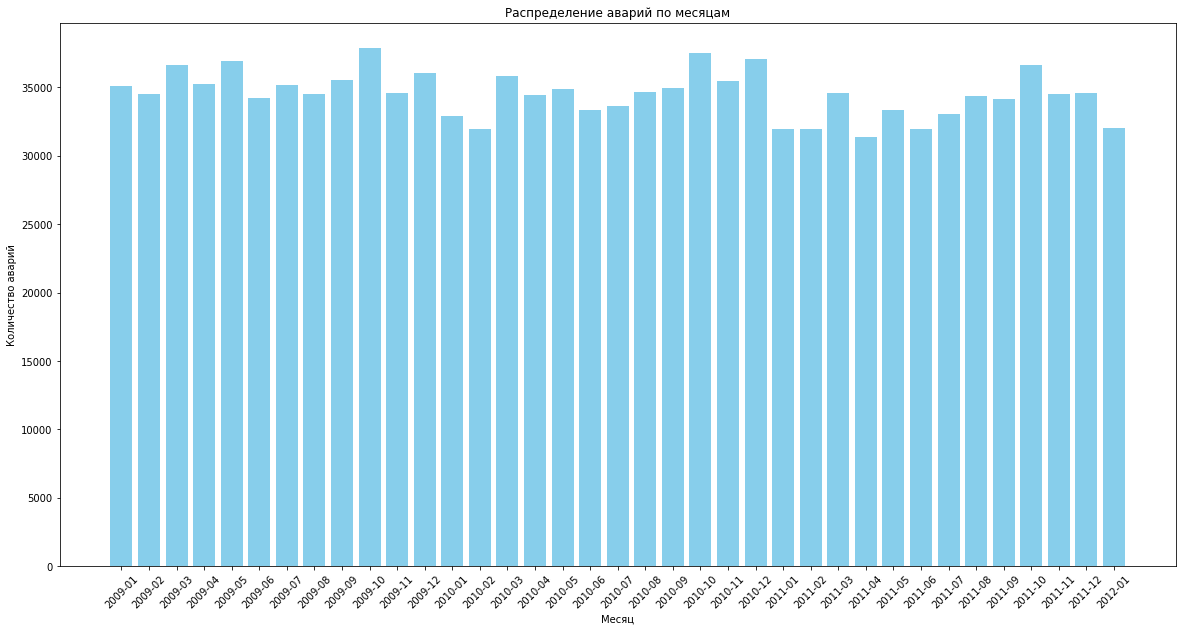

In [16]:
all_months = pd.date_range(start='01-01-2009', end='01-12-2012', freq='MS').to_period('M')
if not pd.api.types.is_period_dtype(collisions_count['month']):
    collisions_count['month'] = pd.to_datetime(collisions_count['month']).dt.to_period('M')
merged_data = collisions_count.set_index('month').reindex(all_months, fill_value=0).reset_index()

plt.figure(figsize=(20, 10))
plt.bar(merged_data['index'].astype(str), merged_data['count'], color='skyblue')
plt.title('Распределение аварий по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество аварий')
plt.xticks(rotation=45)
plt.show()

<b>Вывод</b>

На графике прослеживается сезонное увеличение количества аварий весене-осений периоды: с марта по май и с сентября по декабрь. 

<b> Аналитические задачи</b>
 - Доля застрахованных автомобилей, среди виновых и невиновых участников
 - Автомобили с каким кузовом чаще всего попадают в аварии
 - Влияние дорожного состояния на количество аварий
 - Влияние погодных условий на количество аварий
 - Регионы с самым большим количеством аварий
 - В какое время суток (освещение) происходит больше всего аварий




##### Доля застрахованных автомобилей, среди виновых и невиновых участников

In [17]:
query = """
SELECT 
    c.case_id,
    p.at_fault,
    CASE 
        WHEN p.insurance_premium IS NOT NULL AND p.insurance_premium > 0 THEN 1
        ELSE 0 
    END AS is_insured
FROM 
    collisions c
JOIN 
    parties p ON c.case_id = p.case_id 
WHERE p.party_type = 'car'
"""
df_ins = pd.read_sql_query(query, con=engine)

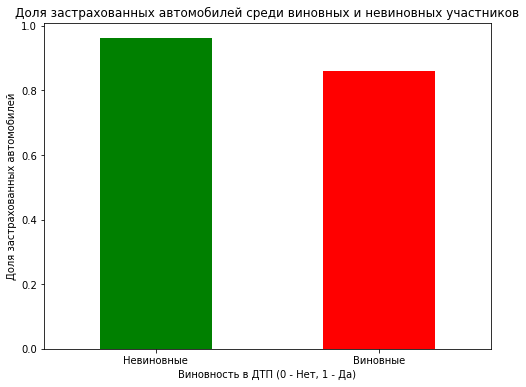

In [18]:
insured_stats = df_ins.groupby('at_fault')['is_insured'].mean()

plt.figure(figsize=(8, 6))
insured_stats.plot(kind='bar', color=['green', 'red'])
plt.title('Доля застрахованных автомобилей среди виновных и невиновных участников')
plt.xlabel('Виновность в ДТП (0 - Нет, 1 - Да)')
plt.ylabel('Доля застрахованных автомобилей')
plt.xticks(ticks=[0, 1], labels=['Невиновные', 'Виновные'], rotation=0)
plt.show()

<b>Вывод</b>

Автомобили, которые являются виновниками ДТП, реже бывают застрахованы.

##### Автомобили с каким кузовом чаще всего попадают в аварии

In [19]:
query = """
SELECT 
    v.vehicle_type,
    COUNT(*) AS accident_count
FROM 
    vehicles v
JOIN 
    collisions c ON v.case_id = c.case_id
GROUP BY 
    v.vehicle_type
ORDER BY 
    accident_count DESC
"""
df_vehicle_type = pd.read_sql_query(query, con=engine)

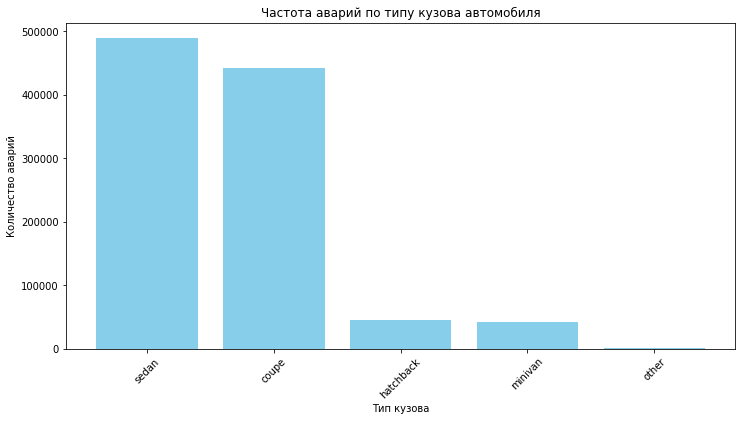

In [20]:
plt.figure(figsize=(12, 6))
plt.bar(df_vehicle_type['vehicle_type'], df_vehicle_type['accident_count'], color='skyblue')
plt.title('Частота аварий по типу кузова автомобиля')
plt.xlabel('Тип кузова')
plt.ylabel('Количество аварий')
plt.xticks(rotation=45)
plt.show()

<b>Вывод </b>

Из график видно, что чаще всего попадают в аварии седаны и купе.

<b>Общий вывод</b>

- Было проведено три исследнования:
 - Количества аварий увеличивается весене-осений периоды: с марта по май и с сентября по декабрь.
 - Автомобили, которые являются виновниками ДТП, реже бывают застрахованы.
 - В аварии чаще попадают автомобили с типом кузова седан и купе.
 
 
- Сформулированы задачи для дополнительного аналитического исследования:
 - Влияние дорожного состояния на количество аварий
 - Влияние погодных условий на количество аварий
 - Регионы с самым большим количеством аварий
 - В какое время суток (освещение) происходит больше всего аварий

## Создайте модель для оценки водительского риска

Подготовим набор данных на основе первичного предположения заказчика:
 - Тип виновника — только машина (car). **
 - возьмем случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
 - Данные только за 2012 год.

In [21]:
query = '''
SELECT
    c.distance,
    c.direction,
    c.weather_1,
    c.location_type,
    c.road_surface,
    c.road_condition_1,
    c.lighting,
    c.control_device,
    c.collision_date,
    p.at_fault,
    p.insurance_premium,
    p.party_sobriety,
    p.party_drug_physical,
    v.vehicle_type,
    v.vehicle_transmission,
    v.vehicle_age
FROM
    collisions c
JOIN
    parties p ON c.case_id = p.case_id
JOIN 
    vehicles v ON c.case_id = v.case_id
WHERE
    p.party_type = 'car'
    AND c.collision_damage != 'scratch'
    AND c.collision_date BETWEEN '2012-01-01' AND '2012-12-31';
'''
df = pd.read_sql_query(query, con=engine)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   distance              118411 non-null  float64
 1   direction             89466 non-null   object 
 2   weather_1             118022 non-null  object 
 3   location_type         55137 non-null   object 
 4   road_surface          117645 non-null  object 
 5   road_condition_1      117843 non-null  object 
 6   lighting              118080 non-null  object 
 7   control_device        117957 non-null  object 
 8   collision_date        118411 non-null  object 
 9   at_fault              118411 non-null  int64  
 10  insurance_premium     113289 non-null  float64
 11  party_sobriety        116682 non-null  object 
 12  party_drug_physical   8695 non-null    object 
 13  vehicle_type          118411 non-null  object 
 14  vehicle_transmission  116545 non-null  object 
 15  

In [23]:
display(df.head())
display(df.tail())

,distance,direction,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_date,at_fault,insurance_premium,party_sobriety,party_drug_physical,vehicle_type,vehicle_transmission,vehicle_age
0,413.0,east,clear,None,dry,normal,daylight,none,2012-01-05,1,86.0,had not been drinking,None,coupe,auto,13.0
1,1079.0,north,clear,None,dry,normal,daylight,none,2012-01-01,0,53.0,had not been drinking,None,sedan,manual,3.0
2,1079.0,north,clear,None,dry,normal,daylight,none,2012-01-01,0,53.0,had not been drinking,None,coupe,manual,5.0
3,2534.0,south,clear,highway,dry,normal,daylight,none,2012-01-24,1,72.0,had not been drinking,None,coupe,manual,8.0
4,2534.0,south,clear,highway,dry,normal,daylight,none,2012-01-24,1,72.0,had not been drinking,None,coupe,auto,11.0


,distance,direction,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_date,at_fault,insurance_premium,party_sobriety,party_drug_physical,vehicle_type,vehicle_transmission,vehicle_age
118406,1056.0,east,clear,highway,dry,normal,daylight,none,2012-01-25,0,58.0,had not been drinking,None,sedan,manual,3.0
118407,1056.0,east,clear,highway,dry,normal,daylight,none,2012-01-25,1,22.0,had not been drinking,None,sedan,auto,7.0
118408,1056.0,east,clear,highway,dry,normal,daylight,none,2012-01-25,1,22.0,had not been drinking,None,sedan,manual,3.0
118409,1056.0,east,clear,highway,dry,normal,daylight,none,2012-01-25,0,59.0,had not been drinking,None,sedan,auto,7.0
118410,1056.0,east,clear,highway,dry,normal,daylight,none,2012-01-25,0,59.0,had not been drinking,None,sedan,manual,3.0


Проверим пропуски

In [24]:
df.isna().sum()

distance                     0
direction                28945
weather_1                  389
location_type            63274
road_surface               766
road_condition_1           568
lighting                   331
control_device             454
collision_date               0
at_fault                     0
insurance_premium         5122
party_sobriety            1729
party_drug_physical     109716
vehicle_type                 0
vehicle_transmission      1866
vehicle_age               3365
dtype: int64

`distance`

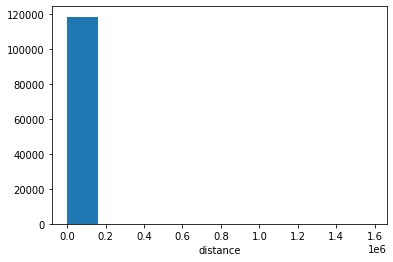

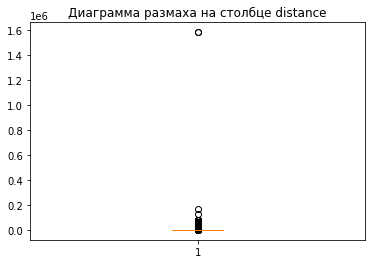

In [25]:
plt.hist(df['distance'])
plt.xlabel('distance')
plt.show()

plt.boxplot(df['distance'])
plt.title('Диаграмма размаха на столбце distance')
plt.show()

Удалим экстремальное значение

In [26]:
df.drop(index=df[df['distance'] > df['distance'].quantile(0.99)].index, inplace=True)

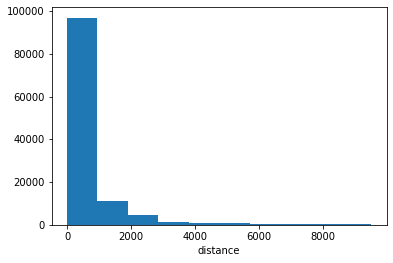

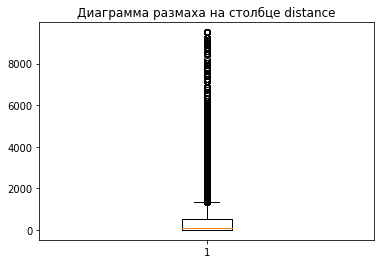

In [27]:
plt.hist(df['distance'])
plt.xlabel('distance')
plt.show()

plt.boxplot(df['distance'])
plt.title('Диаграмма размаха на столбце distance')
plt.show()

 <b>direction</b>

In [28]:
df['direction'].value_counts()

north    24808
south    24448
west     19878
east     19197
Name: direction, dtype: int64

Заполним пропуски

In [29]:
df['direction'] = df['direction'].fillna('unknown')

In [30]:
df['direction'].value_counts()

unknown    28944
north      24808
south      24448
west       19878
east       19197
Name: direction, dtype: int64

<b>weather_1</b>

In [31]:
df['weather_1'].value_counts()

clear      95161
cloudy     16838
raining     4177
fog          383
snowing      246
other         58
wind          23
Name: weather_1, dtype: int64

Объединим wind с other, пропуски заполним other

In [32]:
df['weather_1'] = df['weather_1'].fillna('other')
df["weather_1"] = df["weather_1"].replace("wind", 'other')

In [33]:
df['weather_1'].value_counts()

clear      95161
cloudy     16838
raining     4177
other        470
fog          383
snowing      246
Name: weather_1, dtype: int64

<b>location_type</b>

In [34]:
df['location_type'].value_counts()

highway         45195
ramp             6255
intersection     2866
Name: location_type, dtype: int64

Заполним пропуски

In [35]:
df['location_type'] = df['location_type'].fillna('unknown')

In [36]:
df['location_type'].value_counts()

unknown         62959
highway         45195
ramp             6255
intersection     2866
Name: location_type, dtype: int64

<b>road_surface</b>

In [41]:
df['road_surface'].value_counts()

dry         105958
wet           9971
snowy          515
slippery        70
Name: road_surface, dtype: int64

Заполним пропуски

In [42]:
df['road_surface'] = df['road_surface'].fillna('unknown')

In [43]:
df['road_surface'].value_counts()

dry         105958
wet           9971
unknown        761
snowy          515
slippery        70
Name: road_surface, dtype: int64

<b>road_condition_1</b>

In [44]:
df['road_condition_1'].value_counts()

normal            112761
construction        2261
holes                469
obstruction          444
other                414
loose material       175
reduced width        127
flooded               56
Name: road_condition_1, dtype: int64

Заполним значения, которые встречаются меньше 1000 в категорию other, пропуски заполним other

In [45]:
df['road_condition_1'] = df['road_condition_1'].fillna('other')

In [46]:
df["road_condition_1"] = df["road_condition_1"].replace(["holes", 
                                                        "obstruction", 
                                                        "other equipment", 
                                                        "loose material", 
                                                        "reduced width", 
                                                        "flooded "], 'other')

In [47]:
df['road_condition_1'].value_counts()

normal          112761
construction      2261
other             2197
flooded             56
Name: road_condition_1, dtype: int64

<b>lighting</b>

In [48]:
df['lighting'].value_counts()

daylight                                   82185
dark with street lights                    22030
dark with no street lights                  8765
dusk or dawn                                3679
dark with street lights not functioning      287
Name: lighting, dtype: int64

Две последних категории объеденим в одну, пропуски заполним uknown

In [49]:
df['lighting'] = df['lighting'].fillna('other')

In [50]:
df["lighting"] = df["lighting"].replace("dark with street lights not functioning", 'dusk or dawn')

In [51]:
df['lighting'].value_counts()

daylight                      82185
dark with street lights       22030
dark with no street lights     8765
dusk or dawn                   3966
other                           329
Name: lighting, dtype: int64

<b>control_device</b>

In [52]:
df['control_device'].value_counts()

none               75629
functioning        40889
not functioning      242
obscured              62
Name: control_device, dtype: int64

Заменим две последние категории и пропуски на none

In [53]:
df['control_device'] = df['control_device'].fillna('none')

In [54]:
df["control_device"] = df["control_device"].replace(["not functioning", "obscured"], 'none')

In [55]:
df['control_device'].value_counts()

none           76386
functioning    40889
Name: control_device, dtype: int64

<b>collision_date</b>

In [56]:
df['collision_date'] = pd.to_datetime(df['collision_date'])

In [57]:
df['month'] = df['collision_date'].dt.month

In [58]:
df['month'].value_counts().sort_index()

1     22722
2     21696
3     24173
4     22182
5     20069
6      2671
7       668
8       811
9       750
10      519
11      562
12      452
Name: month, dtype: int64

За второе полугодие аномально мало значение, поэтому удалим этот столбец

In [59]:
df = df.drop(columns=['month', 'collision_date'])

<b>insurance_premium</b>

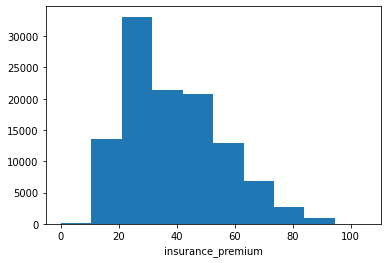

In [60]:
plt.hist(df['insurance_premium'])
plt.xlabel('insurance_premium')
plt.show()

Сделаем этого числового признака категориальный. 0 оставим нулем, пустые значения заполним unkown,  остальные - единицей

In [61]:
df['insurance_premium'] = df['insurance_premium'].fillna(0)

In [62]:
df['insurance_premium'] = df['insurance_premium'].apply(lambda x: 1 if isinstance(x, (int, float)) and x != 0 else x)

In [63]:
df['insurance_premium'].value_counts()

1.0    112160
0.0      5115
Name: insurance_premium, dtype: int64

 <b>party_sobriety</b>

In [64]:
df['party_sobriety'].value_counts()

had not been drinking                     100990
had been drinking, under influence          6424
impairment unknown                          6058
had been drinking, not under influence       963
not applicable                               580
had been drinking, impairment unknown        548
Name: party_sobriety, dtype: int64

Пропуски заполним impairment unknown 

In [65]:
df['party_sobriety'] = df['party_sobriety'].fillna('impairment unknown')

In [66]:
df['party_sobriety'].value_counts()

had not been drinking                     100990
impairment unknown                          7770
had been drinking, under influence          6424
had been drinking, not under influence       963
not applicable                               580
had been drinking, impairment unknown        548
Name: party_sobriety, dtype: int64

<b>party_drug_physical</b>

In [67]:
df['party_drug_physical'].value_counts()

G                        6058
under drug influence     1277
not applicable            580
sleepy/fatigued           506
impairment - physical     175
Name: party_drug_physical, dtype: int64

Заменим катерию not applicable, G и пропуски на  impairment_unknown

In [68]:
df['party_drug_physical'] = df['party_drug_physical'].fillna('impairment unknown')

In [69]:
df["party_drug_physical"] = df["party_drug_physical"].replace(["not applicable", "G"], 'impairment unknown')

In [70]:
df['party_drug_physical'].value_counts()

impairment unknown       115317
under drug influence       1277
sleepy/fatigued             506
impairment - physical       175
Name: party_drug_physical, dtype: int64

<b>vehicle_type</b>

In [71]:
df['vehicle_type'].value_counts()

sedan        76090
coupe        35412
hatchback     3282
minivan       2433
other           58
Name: vehicle_type, dtype: int64

Последние три категории заменим на other

In [72]:
df["vehicle_type"] = df["vehicle_type"].replace(["hatchback", "minivan"], 'other')

In [73]:
df['vehicle_type'].value_counts()

sedan    76090
coupe    35412
other     5773
Name: vehicle_type, dtype: int64

<b>vehicle_transmission</b>

In [74]:
df['vehicle_transmission'].value_counts()

manual    60251
auto      55167
Name: vehicle_transmission, dtype: int64

Удалим строчки, в которых пропуски

In [75]:
df = df.dropna(subset=['vehicle_transmission'])

In [76]:
df.reset_index(drop=True, inplace=True)

<b>vehicle_age</b>

In [77]:
df['vehicle_age'].describe()

count    112629.000000
mean          4.899591
std           3.270111
min           0.000000
25%           3.000000
50%           4.000000
75%           7.000000
max         161.000000
Name: vehicle_age, dtype: float64

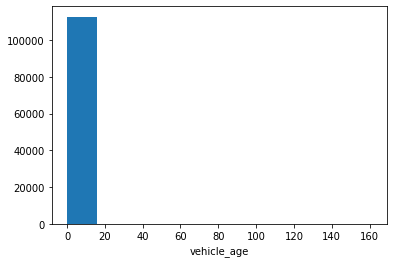

In [78]:
plt.hist(df['vehicle_age'])
plt.xlabel('vehicle_age')
plt.show()


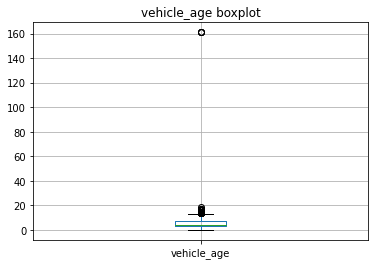

In [79]:
df.boxplot(column = 'vehicle_age')
plt.title('vehicle_age boxplot')
plt.show()

Заменим значения больше 15 на 15, пропуски медианой

In [80]:
df = df.copy()
df.loc[:, 'vehicle_age'] = df['vehicle_age'].apply(lambda x: 15 if x > 15 else x)

In [81]:
df['vehicle_age'] = df['vehicle_age'].fillna(df['vehicle_age'].median())

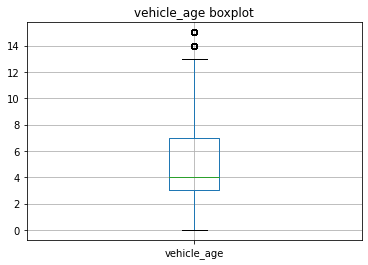

In [82]:
df.boxplot(column = 'vehicle_age')
plt.title('vehicle_age boxplot')
plt.show()

Проверим пропуски и дубликаты

In [83]:
df.isna().sum()

distance                0
direction               0
weather_1               0
location_type           0
road_surface            0
road_condition_1        0
lighting                0
control_device          0
at_fault                0
insurance_premium       0
party_sobriety          0
party_drug_physical     0
vehicle_type            0
vehicle_transmission    0
vehicle_age             0
dtype: int64

In [84]:
df.duplicated().sum()

43653

Удалим дубликаты

In [85]:
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

In [86]:
df.duplicated().sum()

0

<b>at_fault</b>

In [87]:
df.at_fault.value_counts(normalize = True)

1    0.553766
0    0.446234
Name: at_fault, dtype: float64

Есть небольшой перекос в классах, но не значительный, поэтому исправлять не будем.

#####  Подготовка данных для обучения

In [88]:
df = df.copy()

In [89]:
target = ['at_fault']
numeric = ['distance']
category = list(set(df.columns) - set(numeric) - set(target))
category, numeric

(['lighting',
  'location_type',
  'weather_1',
  'road_condition_1',
  'road_surface',
  'party_drug_physical',
  'insurance_premium',
  'control_device',
  'direction',
  'party_sobriety',
  'vehicle_type',
  'vehicle_age',
  'vehicle_transmission'],
 ['distance'])

In [90]:
X = df.drop(target, axis = 1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, shuffle=True, random_state = 42)

Масштабируем признаки

In [91]:
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
X_val[numeric] = scaler.transform(X_val[numeric])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Категоризируем данные

In [92]:
enc = OneHotEncoder(handle_unknown='error', sparse = 'False', drop='first')
enc.fit(X_train[category])
X_train_c =pd.DataFrame(enc.transform(X_train[category]).toarray(), index = X_train.index)
X_val_c =pd.DataFrame(enc.transform(X_val[category]).toarray(), index = X_val.index)
X_test_c =pd.DataFrame(enc.transform(X_test[category]).toarray(), index = X_test.index)

X_train =  X_train.drop(category, axis = 1).join(X_train_c)
X_val = X_val.drop(category, axis = 1).join(X_val_c)
X_test = X_test.drop(category, axis = 1).join(X_test_c)

In [94]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
y_val = y_val.values.ravel()

#### Вывод

Были отобраные признаки для обучения модели, обработаны пропуски, выбросы и дубликаты. Сильного дисбаланса классов не налюдается. Проведено масштабирование числовых признаков и категоризация остальных

## Обчение моделей

Обучим три модели: логистическа регрессия, градиетный бустинг, нейронная сеть.
В качестве метрики выберем Recall потому исходя из постановки задачи нам важно минимизировать ложноотрицательные случаи.

### LogisticRegression

In [95]:
model = LogisticRegression(random_state=42)

In [96]:
param_grid = {
    'C': [0.1, 1.0, 10, 100], 
    'solver': ['liblinear', 'lbfgs'], 
    'max_iter': [100, 200, 300]  
}

# Создание scorer для использования Recall
#scorer = make_scorer(recall_score)

# Создание и запуск GridSearchCV
grid_search = GridSearchCV(model, param_grid, scoring='recall', cv=5)


In [97]:
grid_search.fit(X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 1.0, 10, 100], 'max_iter': [100, 200, 300],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='recall')

In [100]:
lr_best_model = grid_search.best_estimator_

lr_train_recall = grid_search.best_score_
#val_pred = lr_best_model.predict(X_val)
#lr_val_recall = recall_score(y_val, val_pred)

print("Лучшие параметры:", grid_search.best_params_)
print("Recall на кросс-валидации:", lr_train_recall)
#print("Recall на валидационном наборе:", lgb_val_recall)

Лучшие параметры: {'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}
Recall на кросс-валидации: 0.615600201432838


### LGBMClassifier

In [101]:
model = lgb.LGBMClassifier(random_state=42)

In [102]:
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200, 300]
}

#scorer = make_scorer(recall_score)

In [103]:
grid_search = GridSearchCV(model, param_grid, scoring='recall', cv=5)

In [104]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.01],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [31, 50, 100]},
             scoring='recall')

In [107]:
lgb_best_model = grid_search.best_estimator_

lgb_train_recall = grid_search.best_score_
#val_pred = lgb_best_model.predict(X_val)
#lgb_val_recall = recall_score(y_val, val_pred)

print("Лучшие параметры:", grid_search.best_params_)
print("Recall на кросс-валидации:", lgb_train_recall)
#print("Recall на валидационном наборе:", lgb_val_recall)

Лучшие параметры: {'learning_rate': 0.01, 'n_estimators': 100, 'num_leaves': 31}
Recall на кросс-валидации: 0.8693057564149698


 ### Neural Net

In [109]:
X_train_t = torch.FloatTensor(X_train.values)
X_val_t = torch.FloatTensor(X_val.values)
y_train_t = torch.FloatTensor(y_train).flatten()
y_val_t = torch.FloatTensor(y_val).flatten()

In [110]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 25
n_hidden_neurons_2 = 10
n_out_neurons = 1 

In [111]:
net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(), 
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(), 
    nn.Linear(n_hidden_neurons_2, n_out_neurons),
    nn.Sigmoid()
) 
loss = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [120]:
def net_train(num_epochs, num_test):
    recall = Recall(num_classes=2, average='micro', task='binary')
    for epoch in range(num_epochs):
        net.train()
        optimizer.zero_grad()
        preds = net.forward(X_train_t).flatten()
        loss_value = loss(preds, y_train_t)
        loss_value.backward()
        optimizer.step()

        if epoch % num_test == 0 or epoch == num_epochs - 1:
            net.eval()
            with torch.no_grad():
                test_preds = net.forward(X_val_t).flatten()
                recall.update(test_preds, y_val_t)
            test_recall = recall.compute()
            #true_positives = ((test_preds >= 0.5) & (y_val_t == 1)).sum().item()
            #false_negatives = ((test_preds < 0.5) & (y_val_t == 1)).sum().item()
            #recall = true_positives / (true_positives + false_negatives)
            print(f'Epoch {epoch}, Recall: {test_recall}')

In [121]:
num_epochs = 1000
num_test = 10
net_train(num_epochs, num_test)

Epoch 0, Recall: 0.8244897723197937
Epoch 10, Recall: 0.9122449159622192
Epoch 20, Recall: 0.9414966106414795
Epoch 30, Recall: 0.9561224579811096
Epoch 40, Recall: 0.9648979306221008
Epoch 50, Recall: 0.9679988622665405
Epoch 60, Recall: 0.9584547877311707
Epoch 70, Recall: 0.9346938729286194
Epoch 80, Recall: 0.9079743027687073
Epoch 90, Recall: 0.8822789192199707
Epoch 100, Recall: 0.8589208126068115
Epoch 110, Recall: 0.837740957736969
Epoch 120, Recall: 0.8194400668144226
Epoch 130, Recall: 0.8041423559188843
Epoch 140, Recall: 0.7906008958816528
Epoch 150, Recall: 0.7780718803405762
Epoch 160, Recall: 0.766476571559906
Epoch 170, Recall: 0.7559807300567627
Epoch 180, Recall: 0.7463659048080444
Epoch 190, Recall: 0.7375935316085815
Epoch 200, Recall: 0.7296808958053589
Epoch 210, Recall: 0.722510814666748
Epoch 220, Recall: 0.7159124612808228
Epoch 230, Recall: 0.7097930908203125
Epoch 240, Recall: 0.7041020393371582
Epoch 250, Recall: 0.6988422274589539
Epoch 260, Recall: 0.69395

<b>Вывод</b>

Модели Logistic Regression и NeuralNeet показали не очень высокие результаты на валидационных данных (recall 0.61).
Лучший результат у модели LGB - recall 0.86

Проверим модель на тестовых данных

In [124]:
lgb_test_pred = lgb_best_model.predict(X_test)
lgb_test_recall = recall_score(y_test, lgb_test_pred)

print("Recall на кросс-валидации:", lgb_train_recall)
print("Recall на тестовом наборе:", lgb_test_recall)

Recall на кросс-валидации: 0.8693057564149698
Recall на тестовом наборе: 0.8640453182272576


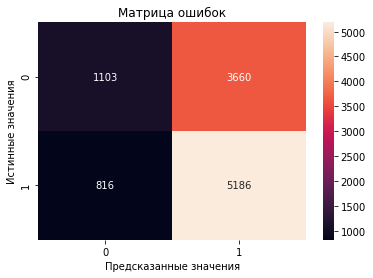

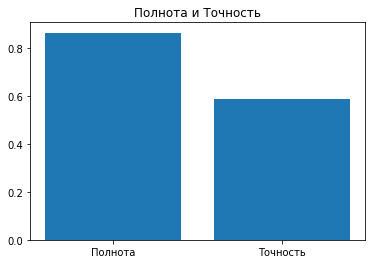

In [125]:
conf_matrix = confusion_matrix(y_test, lgb_test_pred)

sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

recall = recall_score(y_test, lgb_test_pred)
precision = precision_score(y_test, lgb_test_pred)

plt.bar(['Полнота', 'Точность'], [recall, precision])
plt.title('Полнота и Точность')
plt.show()

Модель лучше справляется с обнаружением истинных случаев класса 1 (высокая полнота), чем с точностью их предсказания (средняя точность). Это подходит для решения нашей задачи, т.к. нам необходимо установить вероятность того, что водитель попадет в аварию.

## Проведите анализ важности факторов ДТП

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


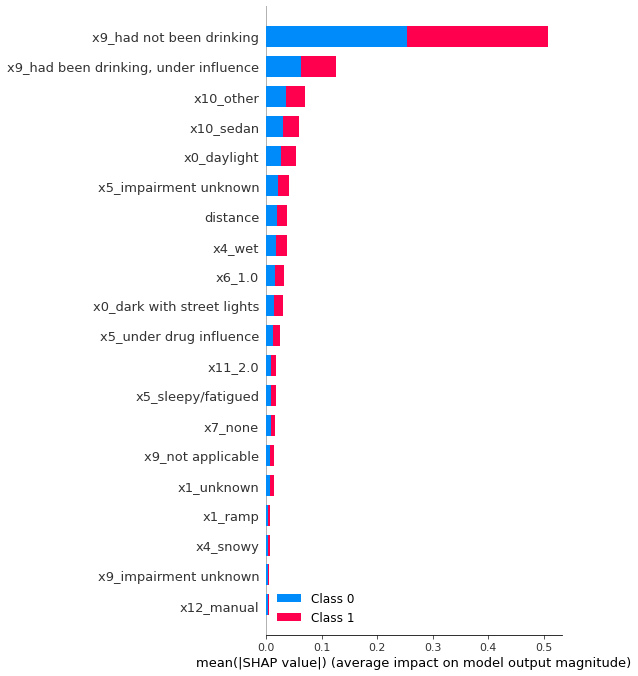

In [126]:
numeric_feature_names = numeric
ohe_feature_names = enc.get_feature_names()
all_feature_names = numeric_feature_names + ohe_feature_names.tolist()
explainer = shap.Explainer(lgb_best_model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val, feature_names=all_feature_names, plot_type="bar")

Самые важные факторы, влияющие на целевую метрику:  трезвость водителя, тип кузова и освещение на улице

<Figure size 2160x2160 with 0 Axes>

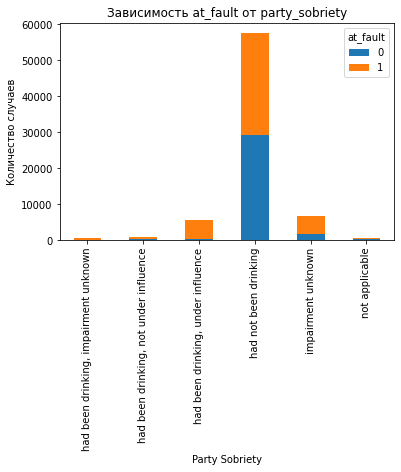

In [127]:
grouped_data = df.groupby('party_sobriety')['at_fault'].value_counts().unstack()
plt.figure(figsize=(30, 30))
grouped_data.plot(kind='bar', stacked=True)
plt.title('Зависимость at_fault от party_sobriety')
plt.xlabel('Party Sobriety')
plt.ylabel('Количество случаев')
plt.show()

Из графика видно что среди трезвых водителей количество виновных и невиновых примерно одинаковое, однако если водитель выпил, то это значительно увеличивает вероятность быть виновником ДТП.

В качестве меру уменьшающей количество нетрезвого вождения автомобиля, можно оборудовать автомобиль анализатором алкогольного опьянения. Измерение состояния при посадке сделать обязательным условием допуска за руль. А чтобы убедиться, что в трубку дышит именно водитель, добавить камеру, направленную на водительское место.

## Выводы

В рамках данной работы было проведенно исследование следующих задач заказчика: разработать систему предсказания аварии и систему предсказания веротности того, что водитель будет виновным в ДТП.

По результатам изучения данных пришли к выводу что первая задача на предоставленных данных не может быть решена, т.к. они содержать информацию только об авариях, в них нет данных о безаварийных поездках. Чтобы научить модель предсказывать вероятность ДТП необходимо использовать оба набора данных и об аварийных поездках и о безаварийных.

Данных для второй задачи оказалось достаточно. Было обчено три модели LogisticRgression, LightGBM и NEuralNEt. ЛУчший результатам показала модель LightGBM с метрикой recall 0.86.

По результатам обучения установлено, что на вероятность стать виновником ДТП влияют такие  факторы как: тип кузова и освещение на улице. В рамках работы предложено решение по снижению случаев управления автомобилем в нетрезвом виде.